## Example of running DeepRL on real PDE data (burgers)



In [1]:
import os
import sys
import numpy as np

current_dir = os.getcwd()
kd_main_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(kd_main_dir)
# Since the juppter's kernel might be running in a different directory
os.chdir(kd_main_dir) 

import scipy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='numpy.*')
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow.*')
from kd.model import DeepRL
from kd.viz.discover_eq2latex import discover_program_to_latex 
from kd.viz.equation_renderer import render_latex_to_image
from kd.viz.deeprl_viz import *


## 1. Load and prepare data

In [2]:
def prepare_data():
    
    data = scipy.io.loadmat('./kd/data_file/burgers2.mat')
    t = np.real(data['t'].flatten()[:,None])
    x = np.real(data['x'].flatten()[:,None])
    Exact = np.real(data['usol']).T  # t first
    X, T = np.meshgrid(x,t)

    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              

    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0) 

    x_len = len(x)
    total_num = X_star.shape[0]
    sample_num = int(total_num*0.1)
    print(f"random sample number: {sample_num} ")
    ID = np.random.choice(total_num, sample_num, replace = False)
    X_u_meas = X_star[ID,:]
    u_meas = u_star[ID,:]
    return X_u_meas, u_meas, lb, ub

In [3]:
model = DeepRL(
    n_samples_per_batch = 500, # Number of generated traversals by agent per batch
    binary_operators = ['add',"mul", "diff","diff2"],
    unary_operators = ['n2'],
)

np.random.seed(42)

x, y, lb, ub = prepare_data()

model.import_inner_data(dataset='Burgers', data_type='regular')

random sample number: 2585 
-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 3.
                  Sequences have maximum length 64.
RepeatConstraint: [add] cannot occur more than 5 times.
TrigConstraint: [diff, diff2] cannot be a descendant of [diff, diff2].
SoftLengthPrior: No description available.
DiffConstraint_left: [x1] cannot be the left child of [diff, diff2].
DiffConstraint_right: [n2, add, mul, diff, diff2, u1] cannot be the right child of [diff, diff2].
DiffConstraint_des: [add] cannot be a descendant of [diff, diff2].
-- BUILDING PRIOR END ---------------



# 2. Train the model

In [4]:
step_output = model.train(n_epochs=51)

print(f"Current best expression is {step_output['expression']} and its reward is {step_output['r']}")

Progress:   0%|                                                              | 0/51 [00:00<?, ?it/s]/Users/hao/Code/proj/kd/env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Progress:   2%|█                                                     | 1/51 [00:01<01:36,  1.93s/it]

Training epoch 2/51, current best R: 0.9520, cost time: 1.92

	** New best
	Reward: 0.951975704788587
	MSE:5.914983969248237e-06
	Traversal: add,diff2,u1,x1,diff,n2,u1,x1
	Expression:
0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)


Progress:  18%|█████████▌                                            | 9/51 [00:04<00:14,  3.00it/s]

Training epoch 10/51, current best R: 0.9520, cost time: 0.29


Progress:  37%|███████████████████▋                                 | 19/51 [00:07<00:09,  3.41it/s]

Training epoch 20/51, current best R: 0.9520, cost time: 0.31


Progress:  57%|██████████████████████████████▏                      | 29/51 [00:10<00:06,  3.63it/s]

Training epoch 30/51, current best R: 0.9520, cost time: 0.25


Progress:  76%|████████████████████████████████████████▌            | 39/51 [00:13<00:03,  3.44it/s]

Training epoch 40/51, current best R: 0.9520, cost time: 0.29


Progress:  96%|██████████████████████████████████████████████████▉  | 49/51 [00:15<00:00,  3.74it/s]

Training epoch 50/51, current best R: 0.9520, cost time: 0.26


Progress: 100%|█████████████████████████████████████████████████████| 51/51 [00:17<00:00,  2.94it/s]

-- Searching End ------------------
[SEARCH DEBUG INFO]: 
self.best_p.str_expression: 0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)
self.best_p.traversal: add,diff2,u1,x1,diff,n2,u1,x1
program: add,diff2,u1,x1,diff,n2,u1,x1
type of first_term_node: <class 'kd.model.discover.stridge.Node'>
first_term_node: diff2(u1,x1)
repr(first_term_node): diff2(u1,x1)
Current best expression is 0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1) and its reward is 0.951975704788587


# 3. Visualization

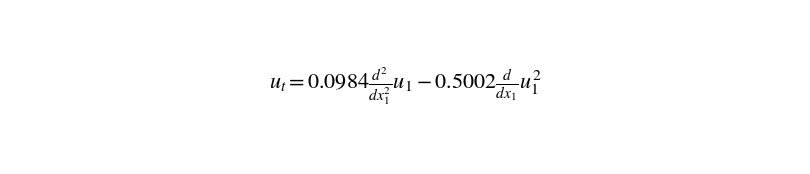

In [5]:
render_latex_to_image(discover_program_to_latex(step_output['program']))

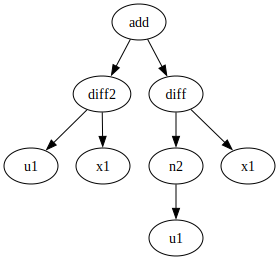

In [6]:
plot_expression_tree(model)

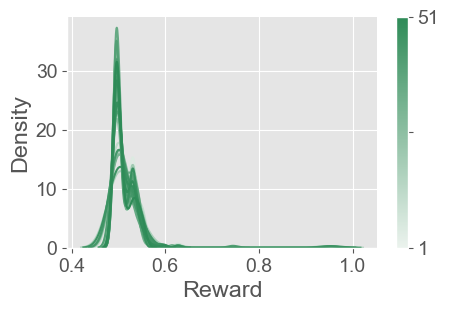

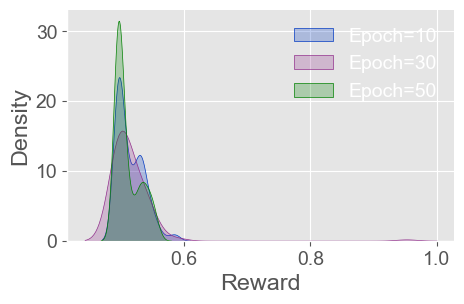

In [7]:
plot_density(model)
plot_density(model, epoches = [10,30,50])

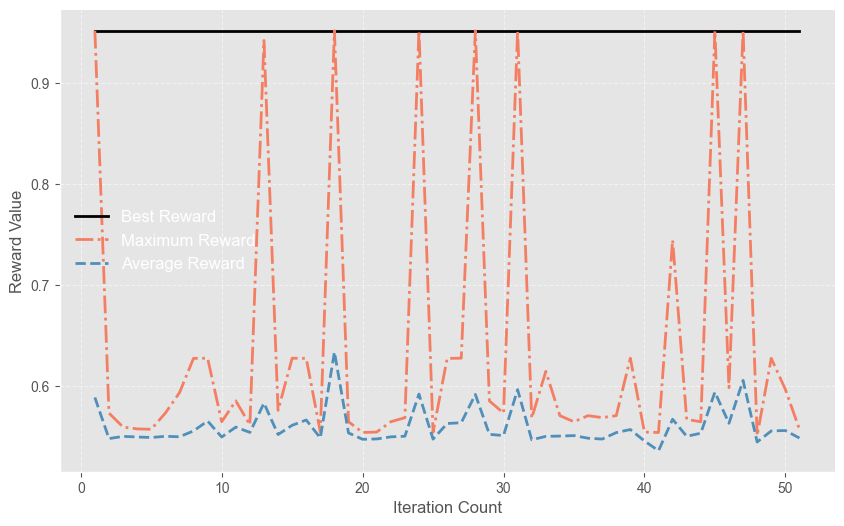

In [8]:
plot_evolution(model)

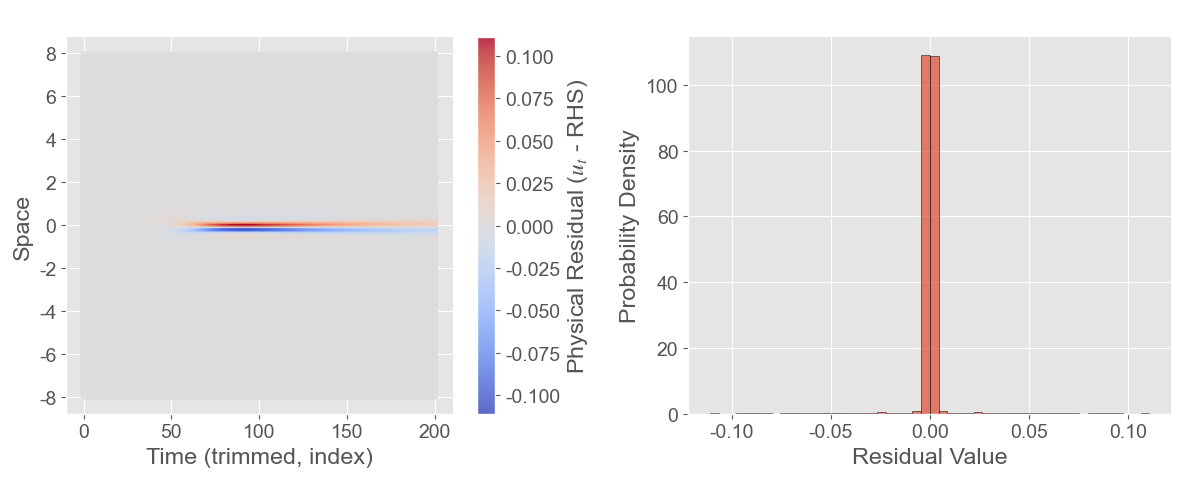

残差数组的形状: (51456,)
坐标数组的形状: (51456, 2)


In [ ]:
plot_pde_residual_analysis(model, step_output['program'])
# 另一种使用方式
residuals, coords = plot_pde_residual_analysis(model, step_output['program'], show_plot=False)
print("残差数组的形状:", residuals.shape)
print("坐标数组的形状:", coords.shape)

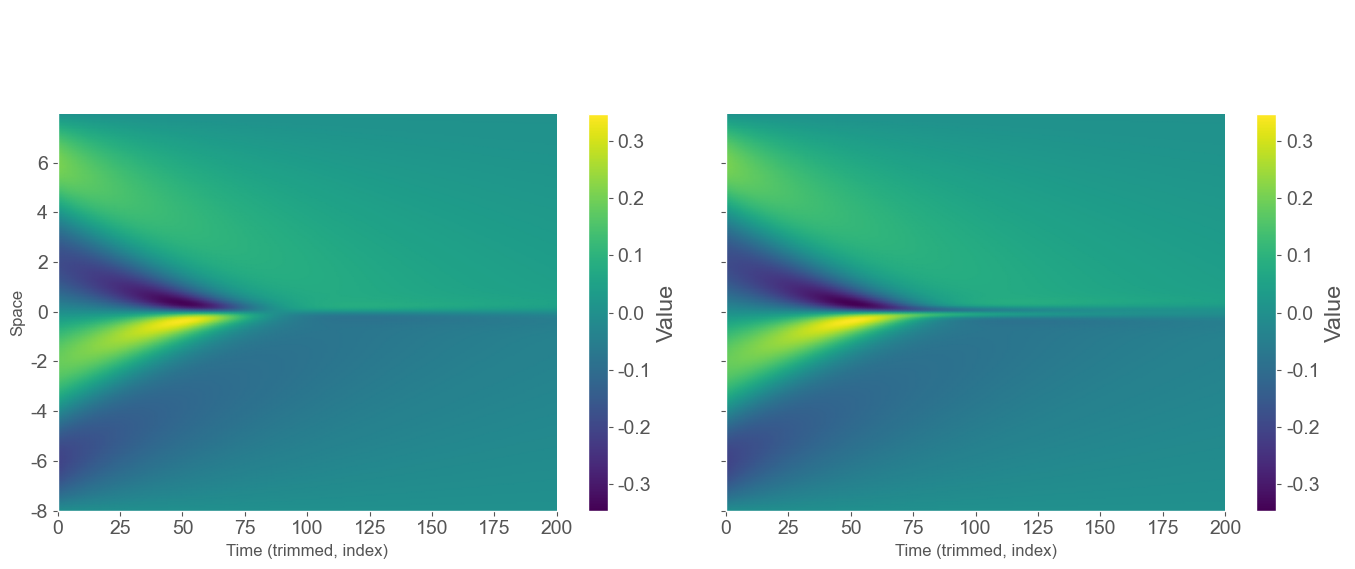

In [10]:
plot_field_comparison(model, step_output['program'])

Generating 'Actual vs. Predicted' plot...


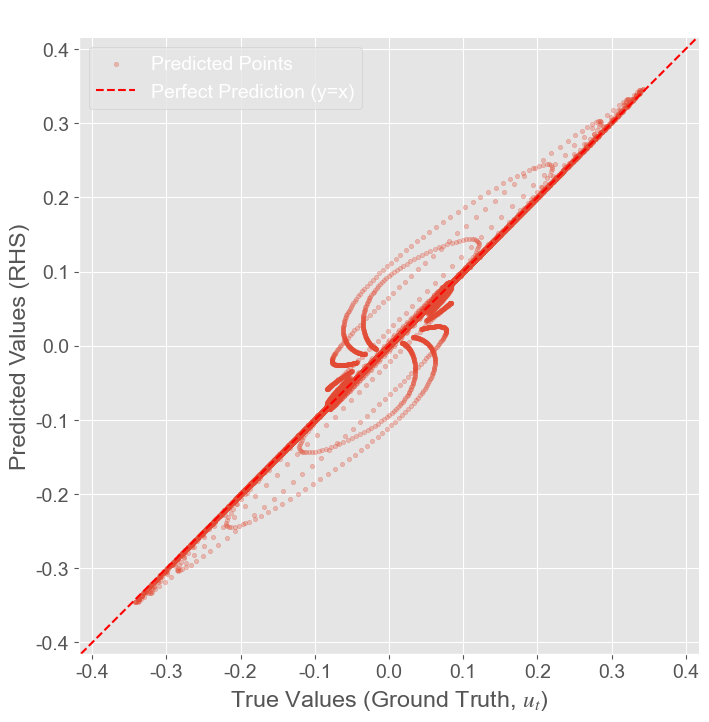

In [11]:
plot_actual_vs_predicted(model, step_output['program'])